# Laboratorio 2

In [1]:
! rm *.c
! rm *.o
! rm *.so
! rm *.asm

In [2]:
import numpy
import random


1. Implementar una función en Python que genere un arreglo de números aleatorios entre 0  y 9

Requerimientos:
*   Entradas: tamaño del arreglo
*   Salida: arreglo de numpy con elementos de 32 bits

In [3]:
def gen_nums(N):
    return numpy.asarray([random.randint(0,9) for _ in range(N)], dtype=numpy.int32)

In [4]:
nums = gen_nums(16)
nums

array([1, 3, 0, 2, 8, 7, 8, 4, 4, 3, 6, 0, 8, 0, 1, 7], dtype=int32)


2.   Implementar una función en Python que detecte los números pares de un arreglo

Requerimientos:



*   Entrada: arreglo de numpy con elementos de 32 bits
*   Salida: arreglo de numpy con elementos de 8 bits




In [5]:
def detectar_pares(nums):
    return numpy.asarray([0 if num % 2 == 0 else 1 for num in nums], dtype=numpy.int8)

In [6]:
output_py = detectar_pares(nums)
output_py

array([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1], dtype=int8)

In [7]:
import ctypes


3.   Implementar una función en Python que detecte los números pares de un arreglo

Requerimientos:



*   Entradas: 
    + Puntero a los elementos de entrada enteros de 32 bits
    + Cantidad de elementos
    + Puntero a los elementos de salida enteros de 8 bits





In [8]:
%%file detectar_pares_c.c
void detectar_pares_c(int* nums, int N, char* output) {
    for(int i = 0; i < N; i++){
        if ((nums[i] % 2) == 0) {
            output[i] = 0;
        }
        else {
            output[i] = 1;
        }
    }
}

Writing detectar_pares_c.c




4.   Generar el *object file* y la *shared library*



In [9]:
# para generar el object file
! gcc -c -Wall -Werror  -fpic  detectar_pares_c.c

# para crear la shared library
! gcc -shared  detectar_pares_c.o -o detectar_pares_c.so



5.   Hacer una función que vincule la librería dinámica de C con Python 



In [10]:
def ctypes_detectar_pares_c():
    # indicar la ruta de la shared library
    libfile = './detectar_pares_c.so'

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos
    lib.detectar_pares_c.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.int32),
        ctypes.c_int,
        numpy.ctypeslib.ndpointer(dtype=numpy.int8)
    ]
    
    # funcion configurada
    return lib.detectar_pares_c



6.   Envolver la función implementada en C para que cumpla con los mismos requerimientos que la función implementada en Pyhon



In [11]:
detectar_pares_c_int = ctypes_detectar_pares_c()

In [12]:
def detectar_pares_c(nums):
  N = len(nums)
  output = numpy.zeros(N).astype(numpy.int8)
  detectar_pares_c_int(nums, N, output)
  return output

In [13]:
output_c = detectar_pares_c(nums)
output_c

array([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1], dtype=int8)

In [14]:
%%file detectar_pares_asm.asm
    global detectar_pares_asm
    section .text
detectar_pares_asm:
    mov r15, 0
compi:
    cmp r15d, esi
    jge done
loopi:
    mov eax, dword [rdi + 4*r15]
    and eax, 1
    mov byte [rdx + r15], al
    inc r15d
    jmp compi
done:
    ret

Writing detectar_pares_asm.asm


In [15]:
! nasm -f elf64 detectar_pares_asm.asm -o detectar_pares_asm.o

In [16]:
! gcc -shared detectar_pares_asm.o -o detectar_pares_asm.so

In [17]:
def ctypes_detectar_pares_asm():
    # indicar la ruta de la shared library
    libfile = './detectar_pares_asm.so'

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos
    lib.detectar_pares_asm.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.int32),
        ctypes.c_int,
        numpy.ctypeslib.ndpointer(dtype=numpy.int8)
    ]
    
    # funcion configurada
    return lib.detectar_pares_asm

In [18]:
detectar_pares_asm_int = ctypes_detectar_pares_asm()

In [19]:
def detectar_pares_asm(nums):
  N = len(nums)
  output = numpy.zeros(N).astype(numpy.int8)
  detectar_pares_asm_int(nums, N, output)
  return output

In [20]:
output_asm = detectar_pares_asm(nums)
output_asm

array([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1], dtype=int8)

In [21]:
nums = gen_nums(16384)
(detectar_pares(nums) == detectar_pares_c(nums)).all(),  (detectar_pares_c(nums) == detectar_pares_asm(nums)).all()

(True, True)




12.   Realice mediciones de tiempo para las funciones implementadas. Las mediciones serán  para la lista de tamaños `[32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]`. Para cada tamaño realice 100 mediciones y filtre sus mediciones con la función `filtro_mediana` con una ventana de 7. Emplee el método `perf_counter` del módulo `time`.



In [22]:
import statistics

def filtro_mediana(sign, ventana):
    signc = []
    tam = len(sign)
    offs = int((ventana-1)/2)
    for i in range(tam):
        inicio = i - offs if (i - offs > 0) else i
        fin = i + offs if (i + offs < tam) else tam
        signc.append(statistics.median(sign[inicio:fin]))
    return signc

In [23]:
# modulo para medir el tiempo
import time

# veces
veces = 100

# tamagnos de los arreglos
sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

# tiempos de python
tpy = numpy.zeros((len(sizes),1),dtype=numpy.float32)

# tiempos de  C
tc = numpy.zeros((len(sizes),1),dtype=numpy.float32)

# tiempos de ASM
tasm = numpy.zeros((len(sizes),1),dtype=numpy.float32)

In [24]:
for i, size in enumerate(sizes):
    tpyi = []
    tci = []
    tasmi = []
    for j in range(veces):
        # entradas
        x = gen_nums(size)
    
        # tiempo PY
        t = time.perf_counter()
        output_py = detectar_pares(x)
        tpyi.append(time.perf_counter() - t)
    
        # tiempo C
        t = time.perf_counter()
        output_c = detectar_pares_c(x)
        tci.append(time.perf_counter() - t)

        # tiempo ASM
        t = time.perf_counter()
        output_asm = detectar_pares_asm(x)
        tasmi.append(time.perf_counter() - t)
    
    tpy[i] = statistics.mean(filtro_mediana(tpyi,7))
    tc[i] = statistics.mean(filtro_mediana(tci,7))
    tasm[i] = statistics.mean(filtro_mediana(tasmi,7))



13.   Presente las siguientes gráficas:
     +   Tiempo vs Tamaño
     +   Speedup vs Tamaño




In [25]:
# modulo para graficar
import matplotlib.pyplot as plt

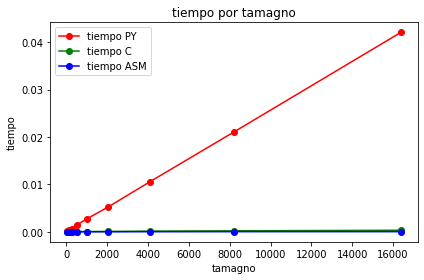

In [26]:
plt.plot(sizes, tpy, 'r-o', label='tiempo PY')
plt.plot(sizes, tc, 'g-o', label='tiempo C')
plt.plot(sizes, tasm, 'b-o', label='tiempo ASM')
plt.title('tiempo por tamagno')
plt.xlabel('tamagno')
plt.ylabel('tiempo')
plt.legend()
plt.tight_layout()

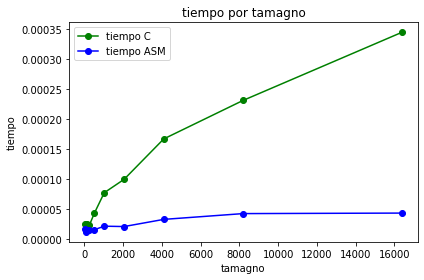

In [27]:
plt.plot(sizes, tc, 'g-o', label='tiempo C')
plt.plot(sizes, tasm, 'b-o', label='tiempo ASM')
plt.title('tiempo por tamagno')
plt.xlabel('tamagno')
plt.ylabel('tiempo')
plt.legend()
plt.tight_layout()

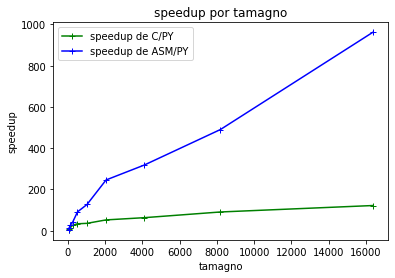

In [28]:
plt.plot(sizes, tpy/tc, 'g-+', label='speedup de C/PY')
plt.plot(sizes, tpy/tasm, 'b-+', label='speedup de ASM/PY')
plt.title('speedup por tamagno')
plt.xlabel('tamagno')
plt.ylabel('speedup')
plt.legend()
plt.show()

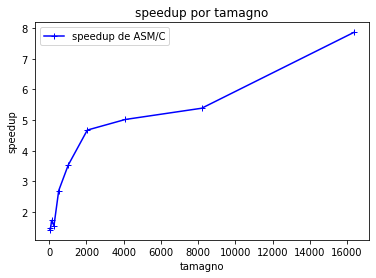

In [29]:
plt.plot(sizes, tc/tasm, 'b-+', label='speedup de ASM/C')
plt.title('speedup por tamagno')
plt.xlabel('tamagno')
plt.ylabel('speedup')
plt.legend()
plt.show()